- test 0,5, 14 files
- train reamining files

-  for file 13  threshold  greatcircle_threshold = 45
-  for file 1 threshold greatcircle_threshold = 13
- for file 4 greatcircle_threshold 13
- for file 12 greatcircle_threshold = 15
- for file 7 greatcircle_threshold = 13
- for file 8 greatcircle_threshold = 8
- for file 11 greatcircle_threshold = 25
- for file 10 greatcircle_threshold = 15

In [ ]:
!unzip traces.zip

Archive:  traces.zip
   creating: traces/
  inflating: traces/hamburg_rounsabouts.csv  
  inflating: traces/trace_0.csv      
  inflating: traces/trace_1.csv      
  inflating: traces/trace_10.csv     
  inflating: traces/trace_11.csv     
  inflating: traces/trace_12.csv     
  inflating: traces/trace_13.csv     
  inflating: traces/trace_14.csv     
  inflating: traces/trace_2.csv      
  inflating: traces/trace_3.csv      
  inflating: traces/trace_4.csv      
  inflating: traces/trace_5.csv      
  inflating: traces/trace_6.csv      
  inflating: traces/trace_7.csv      
  inflating: traces/trace_8.csv      
  inflating: traces/trace_9.csv      


In [11]:
import pandas as pd
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import glob
import plotly.express as px
from geopy.distance import great_circle
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from geopy.distance import geodesic
# Suppress warnings
warnings.filterwarnings('ignore')

In [8]:
pwd

'C:\\Users\\irfan\\OneDrive\\Documents\\HERE_hackathon\\traces'

## **calculates the great-circle distance for each probe point**

In [104]:

def add_distance_columns(df, roundabout_file, bbox_id):
    # Load roundabout data
    roundabouts = pd.read_csv(roundabout_file)
    roundabout_row = roundabouts[roundabouts['bbox'] == bbox_id].iloc[0]
    
    # Extract the latitude and longitude of the roundabout
    lat2 = roundabout_row['latitude']
    lon2 = roundabout_row['longitude']
    
    # Define the distance calculation functions
    def calculate_distance(lat1, lon1, lat2, lon2):
        return great_circle((lat1, lon1), (lat2, lon2)).meters
    
    def euclidean_distance(lat1, lon1, lat2, lon2):
        return np.sqrt((lat2 - lat1)*2 + (lon2 - lon1)*2)  # No .meters here, just the raw value
    
    # def manhattan_distance(lat1, lon1, lat2, lon2):
    #     return np.abs(lat2 - lat1) + np.abs(lon2 - lon1)  # No .meters here, just the raw value

    # Apply the distance calculations to the DataFrame
    df['great_circle'] = df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], lat2, lon2), axis=1)
    df['euclidean_distance'] = df.apply(lambda row: euclidean_distance(row['latitude'], row['longitude'], lat2, lon2), axis=1)
    #df['manhattan_distance'] = df.apply(lambda row: manhattan_distance(row['latitude'], row['longitude'], lat2, lon2), axis=1)

    return df

# Load the trace data and add the distance columns
df = pd.read_csv('trace_9.csv')
bbox_id = 13
df_with_distances = add_distance_columns(df, "hamburg_rounsabouts.csv", bbox_id=bbox_id)

## **Filter and Plot Probe Points Around a Roundabout**

- Speed threshold =30
- heading_threshold_min=10, heading_threshold_max=170
- greatcircle_threshold=20
- Drop rows where 'heading' == 0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = 'traces/trace_9.csv'  # Replace with the actual path
df = pd.read_csv(csv_file_path)

# Known roundabout coordinates (longitude, latitude)
roundabout_coords = {'longitude': 9.905460450000007, 'latitude': 53.6163506500001}

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot the data from the CSV file
plt.scatter(df['longitude'], df['latitude'], color='blue', label='CSV Coordinates')

# Plot the known roundabout coordinates
plt.scatter(roundabout_coords['longitude'], roundabout_coords['latitude'], color='red', label='Roundabout', s=100)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of CSV Coordinates and Roundabout')
plt.legend()

# Show the plot
plt.show()


C:\Users\irfan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


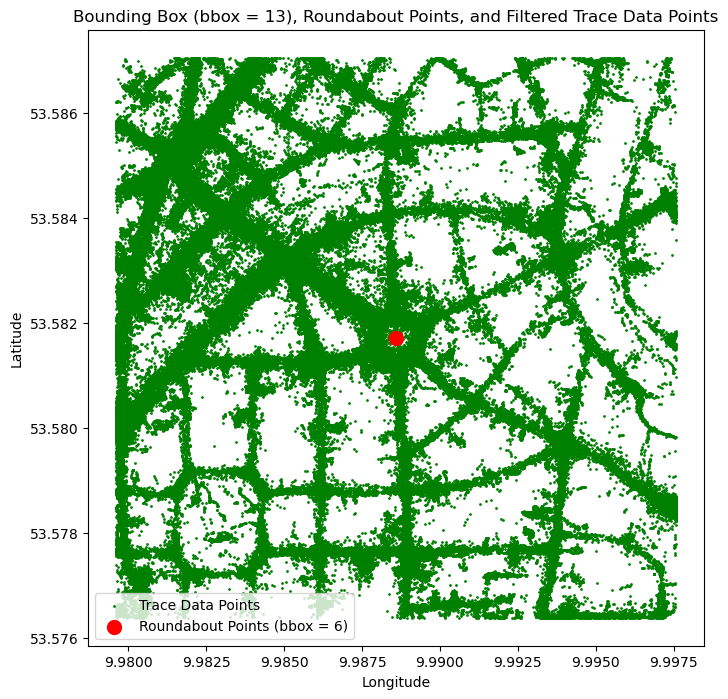

All rows with 'heading' == 0 have been successfully dropped.
DataFrame successfully saved to 'final_trace_13.csv'.


In [105]:
def filter_and_plot_roundabout(df, roundabout_file, bbox_id, greatcircle_threshold, greatcircle_threshold_1, percentile_75, speed_threshold=30, heading_threshold_min=10, heading_threshold_max=170):
    # Load the roundabout data
    roundabout_data = pd.read_csv(roundabout_file)

    # Filter for the specific roundabout bounding box
    roundabout_filtered = roundabout_data[roundabout_data['bbox'] == bbox_id]

    # Step 1: Filter for great-circle distance (Vincenty distance)
    #filtered_trace = df[df['great_circle'] <= greatcircle_threshold]

    # Step 2: Add the LABEL column based on the conditions
        # Label 1 for great_circle < 15
    df.loc[df['great_circle'] < greatcircle_threshold_1, 'LABEL'] = 1

    # Label 0 for great_circle between 25 and 50 and euclidean > 75th percentile
    df.loc[(df['great_circle'] > greatcircle_threshold) & (df['euclidean_distance'] > percentile_75), 'LABEL'] = 0

    # Step 3: Sort by 'traceid' and 'sampledate' for each trace before calculating speed and heading changes
    df = df.sort_values(by=['traceid', 'sampledate'])

    # Step 4: Calculate speed and heading changes within each 'traceid' group
    df['speed_change'] = df.groupby('traceid')['speed'].diff()

    # Define function to calculate heading change
    def calculate_heading_change(heading1, heading2):
        change = heading2 - heading1
        return (change + 180) % 360 - 180  # Normalize heading change between -180 and +180 degrees

    df['heading_change'] = df.groupby('traceid')['heading'].diff().apply(lambda x: calculate_heading_change(x, 0))

    # Step 5: Filter for speed (vehicles slowing down)
    df = df[df['speed'] <= speed_threshold]

    # Step 6: Filter for heading change
    df = df[(df['heading_change'].abs() > heading_threshold_min) &
                                    (df['heading_change'].abs() < heading_threshold_max)]

    # # Step 7: Filter for class 0 with threshold between 30 and 50
    # filtered_trace = filtered_trace[(filtered_trace['class'] == 0) &
    #                                 (filtered_trace['class_column'] >= class_threshold_min) &
    #                                 (filtered_trace['class_column'] <= class_threshold_max)]

    # Convert the roundabout data into a GeoDataFrame
    gdf_roundabout = gpd.GeoDataFrame(
        roundabout_filtered,
        geometry=gpd.points_from_xy(roundabout_filtered['longitude'], roundabout_filtered['latitude']),
        crs="EPSG:4326"
    )

    # Convert the filtered trace data into a GeoDataFrame
    gdf_trace = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['longitude'], df['latitude']),  # Use filtered_trace columns
        crs="EPSG:4326"
    )

    # Step 8: Plot the filtered bounding box polygon, roundabout points, and trace points on the same plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the trace data points
    gdf_trace.plot(ax=ax, color='green', markersize=1, label="Trace Data Points", zorder=2)

    # Plot the roundabout points (bbox = 6)
    gdf_roundabout.plot(ax=ax, color='red', markersize=100, label="Roundabout Points (bbox = 6)", zorder=3)

    # Customize the plot
    plt.title(f"Bounding Box (bbox = {bbox_id}), Roundabout Points, and Filtered Trace Data Points")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()

    # Show the plot
    plt.show()

    # Drop rows where 'heading' == 0
    df_filtered = df[df['heading'] != 0].reset_index(drop=True)

    # Verify the drop
    remaining_zero_headings = df_filtered[df_filtered['heading'] == 0]
    if remaining_zero_headings.empty:
        print("All rows with 'heading' == 0 have been successfully dropped.")
    else:
        print(f"There are still {len(remaining_zero_headings)} rows with 'heading' == 0.")

    # Save the final result with the new LABEL column
    csv_path = f'final_trace_{bbox_id}.csv'
    df_filtered.to_csv(csv_path, index=False)
    print(f"DataFrame successfully saved to '{csv_path}'.")

# Example usage:
greatcircle_threshold_1 = 45
percentile_75_euclidean = df_with_distances['euclidean_distance'].quantile(0.75)
greatcircle_threshold_0 = df_with_distances['great_circle'].quantile(0.75)
filter_and_plot_roundabout(df_with_distances, "hamburg_rounsabouts.csv", bbox_id, greatcircle_threshold_0, greatcircle_threshold_1, percentile_75_euclidean)


In [108]:
df_with_distances.columns

Index(['Unnamed: 0', 'heading', 'latitude', 'longitude', 'traceid',
       'sampledate', 'speed', 'great_circle', 'euclidean_distance', 'LABEL'],
      dtype='object')

In [124]:
def plot_roundabout2(df, speed_threshold=30, heading_threshold_min=10, heading_threshold_max=170):
    # Step 1: Sort by 'traceid' and 'sampledate' for each trace before calculating speed and heading changes
    df = df.sort_values(by=['traceid', 'sampledate'])

    # Step 2: Calculate speed and heading changes within each 'traceid' group
    df['speed_change'] = df.groupby('traceid')['speed'].diff()

    # Define function to calculate heading change
    def calculate_heading_change(heading1, heading2):
        change = heading2 - heading1
        return (change + 180) % 360 - 180  # Normalize heading change between -180 and +180 degrees

    df['heading_change'] = df.groupby('traceid')['heading'].diff().apply(lambda x: calculate_heading_change(x, 0))

    # Step 5: Filter for speed (vehicles slowing down)
    df = df[df['speed'] <= speed_threshold]

    # Step 6: Filter for heading change
    df = df[(df['heading_change'].abs() > heading_threshold_min) &
                                    (df['heading_change'].abs() < heading_threshold_max)]

    df['sampledate'] = pd.to_datetime(df['sampledate'])

    # Sort values by traceid and sampledate
    df = df.sort_values(by=['traceid', 'sampledate'])
    
    # Calculate the time difference in seconds for each traceid group
    df['time_difference'] = df.groupby('traceid')['sampledate'].diff().dt.total_seconds().fillna(0)


    # Drop rows where 'heading' == 0
    df_filtered = df[df['heading'] != 0].reset_index(drop=True)

    # Verify the drop
    remaining_zero_headings = df_filtered[df_filtered['heading'] == 0]
    if remaining_zero_headings.empty:
        print("All rows with 'heading' == 0 have been successfully dropped.")
    else:
        print(f"There are still {len(remaining_zero_headings)} rows with 'heading' == 0.")

    # Save the final result with the new LABEL column
    csv_path = 'final_trace_13.csv'
    df_filtered.to_csv(csv_path, index=False)
    print(f"DataFrame successfully saved to '{csv_path}'.")

df_9 = pd.read_csv('trace_13.csv')
plot_roundabout2(df_9)


All rows with 'heading' == 0 have been successfully dropped.
DataFrame successfully saved to 'final_trace_13.csv'.


In [125]:
dff = pd.read_csv("final_trace_13.csv")
trajectory_data_9 = dff.loc[:, ~dff.columns.str.contains('^Unnamed')]
trajectory_data_9.to_csv('test_trace_13.csv', index=False)
#dff['LABEL'].value_counts()

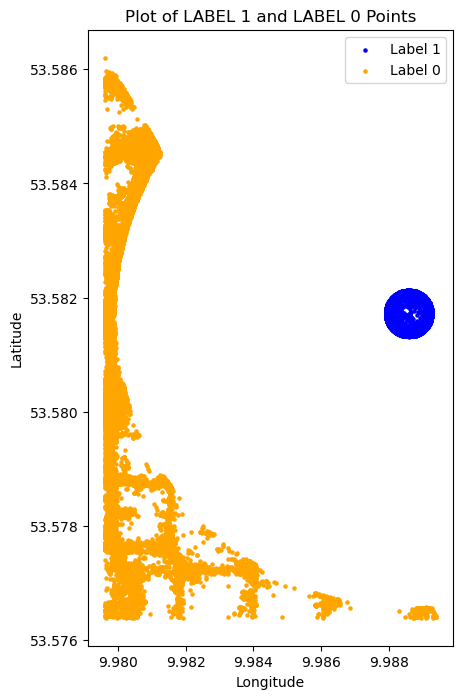

In [107]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_labels(df_path):
    """
    This function reads a CSV file, converts it into a GeoDataFrame, and then plots
    the points labeled as 1 and 0 separately using different colors.

    Parameters:
    df_path (str): Path to the CSV file containing the trace data with 'LABEL' column.

    Returns:
    None
    """
    # Load the CSV data
    df = pd.read_csv(df_path)

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
        crs="EPSG:4326"
    )

    # Filter for LABEL 1 and LABEL 0
    gdf_label_1 = gdf[gdf['LABEL'] == 1]
    gdf_label_0 = gdf[gdf['LABEL'] == 0]

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot LABEL 1 points
    gdf_label_1.plot(ax=ax, color='blue', markersize=5, label="Label 1", zorder=2)

    # Plot LABEL 0 points
    gdf_label_0.plot(ax=ax, color='orange', markersize=5, label="Label 0", zorder=1)

    # Customize the plot
    plt.title("Plot of LABEL 1 and LABEL 0 Points")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()

    # Show the plot
    plt.show()

# Example usage
plot_labels("final_trace_13.csv")
